In [42]:
import importlib
import subprocess
import sys
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing

from causalml.metrics import plot_gain, auuc_score, plot_qini
from causalml.feature_selection.filters import FilterSelect
import causalml
from sklift.metrics import qini_auc_score


import kuplift as kp
import warnings
warnings.filterwarnings('ignore')


# Helper function

In [43]:
def create_prediction_table(df_test, preds, treatment_name, outcome_name):
    """
    Create a DataFrame containing treatment value, outcome value and predictions
    
    Parameters:
    - df_test        : DataFrame containing the test data.
    - preds          : List of differences between treatment and control predictions for each instance.
    - treatment_name  : Column name of the treatment variable.
    - outcome_name    : Column name of the outcome variable.

    Returns:
    - df_preds       : DataFrame containing treatment value, outcome value and predictions
    """
    
    df_preds = pd.DataFrame()
    df_preds['Predictions'] = preds
    
    # Reset the indices to ensure proper alignment during DataFrame column assignment
    df_preds['treatment'] = df_test[treatment_name].reset_index()[treatment_name].astype(int)
    df_preds['outcome'] = df_test[outcome_name].reset_index()[outcome_name].astype(int)
    
    return df_preds.copy()

def encode_data(df):
    '''
    Label encoding for the categorical columns in a dataframe df
    '''
    # Create a copy of the input dataframe to ensure original dataframe remains unchanged
    df_encoded = df.copy()
    
    # Get all column names
    input_variables = df.columns
    
    # Identify numeric columns
    num_cols = list(df_encoded._get_numeric_data().columns)
    
    # Identify categorical columns by subtracting numeric columns from all columns
    categorical_cols = list(set(input_variables) - set(num_cols))
    
    # Initialize the label encoder from sklearn
    label_encoder = preprocessing.LabelEncoder()
    
    # Iterate through each categorical column and apply label encoding
    for col in categorical_cols:
        df_encoded.loc[:, col] = label_encoder.fit_transform(df_encoded[col])
    
    # Return the dataframe with encoded columns
    return df_encoded

## Table of contents:
* [1. Load Hillstrom dataset](#1)
    * [1.1. Choose the treatment and outcome variables and transform them to numerical values](#1.1)
    * [1.2. Convert categorical to numerical values](#1.2)
* [3. Create an uplift model using the two-model approach](#3)
    * [3.1. Create treatment and control models](#3.1)
    * [3.2. Fit the models on the train data and get predictions on the test data](#3.2)
* [4. Create an uplift model using the two-model approach with feature selection and variable encoding as a preprocessing step](#4)
* [5. Learn an uplift using UB-DT from the KUPLIFT library](#5)
* [6. Learn an uplift using UB-RF from the KUPLIFT library](#6)
* [7. Implement the class transformation approach](#7)

# load Hillstrom dataset <a class="anchor" id="1"></a>

REF: https://www.uplift-modeling.com/en/v0.3.1/api/datasets/fetch_hillstrom.html

This dataset contains 64,000 customers who last purchased within twelve months. The customers were involved in an e-mail test.
- 1/3 were randomly chosen to receive an e-mail campaign featuring Mens merchandise.
- 1/3 were randomly chosen to receive an e-mail campaign featuring Womens merchandise.
- 1/3 were randomly chosen to not receive an e-mail campaign.

During a period of two weeks following the e-mail campaign, results were tracked.

Historical customer attributes at your disposal include:

- Recency: Months since last purchase.

- History_Segment: Categorization of dollars spent in the past year.

- History: Actual dollar value spent in the past year.

- Mens: 1/0 indicator, 1 = customer purchased Mens merchandise in the past year.

- Womens: 1/0 indicator, 1 = customer purchased Womens merchandise in the past year.

- Zip_Code: Classifies zip code as Urban, Suburban, or Rural.

- Newbie: 1/0 indicator, 1 = New customer in the past twelve months.

- Channel: Describes the channels the customer purchased from in the past year.

Another variable describes the e-mail campaign the customer received:

Segment:
- Mens E-Mail
- Womens E-Mail
- No E-Mail

Finally, we have a series of variables describing activity in the two weeks following delivery of the e-mail campaign:

- Visit: 1/0 indicator, 1 = Customer visited website in the following two weeks.
- Conversion: 1/0 indicator, 1 = Customer purchased merchandise in the following two weeks.
- Spend: Actual dollars spent in the following two weeks.

In [44]:
# Define the name of the CSV file
dataName = '../data/hillstorm_Complete_NotDisc.csv'

# Read the CSV file into a pandas dataframe
hillstrom_df = pd.read_csv(dataName)

# Display the first five rows of the dataframe
hillstrom_df.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0


## Choose the treatment and outcome variables and transform them to numerical values <a class="anchor" id="1.1"></a>

- Treatment variable is 'segment' with only the values 'Womens E-mail' and 'No E-mail'
- Ouctome variable is 'visit'

In [45]:
treatment_name = 'segment'
outcome_name = 'visit'

hillstrom_df.drop(['spend', 'conversion'], axis=1, inplace=True)

input_variables = hillstrom_df.drop([treatment_name, outcome_name], axis=1,inplace=False).columns

print("The different values in the treatment column are\n {} \n\n".format(hillstrom_df[treatment_name].unique()))
print("The different values in the outcome column are\n {}".format(hillstrom_df[outcome_name].unique()))

The different values in the treatment column are
 ['Womens E-Mail' 'No E-Mail' 'Mens E-Mail'] 


The different values in the outcome column are
 [0 1]


In [46]:
hillstrom_df = hillstrom_df[hillstrom_df[treatment_name] != 'Mens E-Mail']

hillstrom_df.loc[:,treatment_name] = hillstrom_df.loc[:,treatment_name].replace({"Womens E-Mail":1,'No E-Mail':0})

## Convert categorical to numerical values <a class="anchor" id="1.2"></a>

In [47]:
# Encode the categorical columns of the dataframe hillstrom_df
encoded_Hillstrom = encode_data(hillstrom_df[input_variables])

# Update the original dataframe hillstrom_df with the encoded values for each categorical column
for col in input_variables:
    hillstrom_df[col] = encoded_Hillstrom[col]

# Create an uplift model using the two-model approach <a class="anchor" id="3"></a>

### Split to train and test splits

In [35]:
df_train, df_test=train_test_split(hillstrom_df)

### Create treatment and control models<a class="anchor" id="3.1"></a>

In [36]:
treatment_model = RandomForestClassifier(n_estimators=5, random_state=99)
control_model = RandomForestClassifier(n_estimators=5, random_state=99)

### fit the models on the train data and get predictions on the test data<a class="anchor" id="3.2"></a>

In [37]:
#  Train the treatment classifier on the treatment group (where treatment_name == 1)
treatment_model.fit(df_train[df_train[treatment_name]==1][input_variables].values, df_train[df_train[treatment_name]==1][outcome_name])
# Predict probabilities using the treatment classifier on the test data
trmntPreds = treatment_model.predict_proba(df_test[input_variables].values)
# Extract the probabilities of positive class (class labeled as 1) from the treatment predictions
treatmentPreds = [pred[1] for pred in trmntPreds]

# Train the control classifier on the control group (where treatment_name == 0)
control_model.fit(df_train[df_train[treatment_name]==0][input_variables].values, df_train[df_train[treatment_name]==0][outcome_name].values)
# Predict probabilities using the control classifier on the test data
CtrlPreds = control_model.predict_proba(df_test[input_variables].values)
# Extract the probabilities of positive class (class labeled as 1) from the control predictions
ControlPreds = [pred[1] for pred in CtrlPreds]

# Calculate the difference between treatment and control predictions for each instance in the test data
preds = [a_i - b_i for a_i, b_i in zip(treatmentPreds, ControlPreds)]

# Create a DataFrame containing the predictions from both classifiers as well as their difference
df_preds_2M = create_prediction_table(df_test, preds, treatment_name, outcome_name)

In [38]:
df_preds_2M

,Predictions,treatment,outcome
0,-0.400000,0,1
1,0.600000,0,0
2,0.200000,1,0
3,0.000000,0,0
4,-0.600000,0,0
...,...,...,...
10669,0.200000,1,0
10670,0.400000,1,0
10671,0.000000,1,0
10672,0.259524,1,0


### Evaluate using the qini metric

In [39]:
# Calculate the qini score
qini = qini_auc_score(y_true=df_preds_2M['outcome'], uplift=df_preds_2M['Predictions'], treatment=df_preds_2M['treatment'])

In [40]:
print(qini)

0.030327523551991517


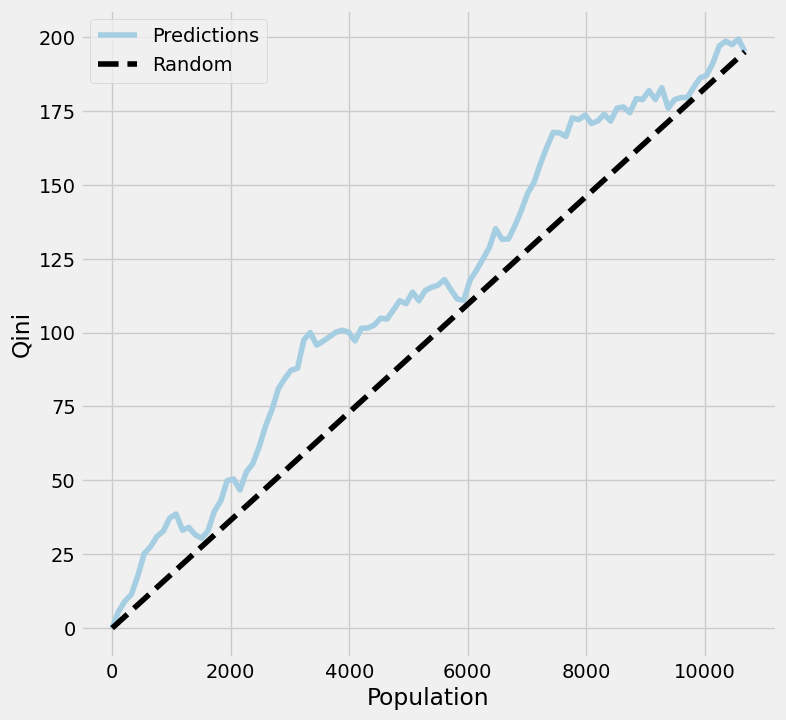

In [41]:
plot_qini(df_preds_2M,outcome_col='outcome',treatment_col='treatment')

# Create an uplift model using the two-model approach with feature selection and variable encoding as a preprocessing step <a class="anchor" id="4"></a>

### Variable transformation

In [17]:
# Univariate variable transformation:
ue = kp.UnivariateEncoding()
encoded_data = ue.fit_transform(hillstrom_df[input_variables], hillstrom_df[treatment_name], hillstrom_df[outcome_name])

informative_features = encoded_data.columns

encoded_data[treatment_name]=hillstrom_df[treatment_name].copy()
encoded_data[outcome_name]=hillstrom_df[outcome_name].copy()



### Split to train and test splits

In [18]:
df_train, df_test=train_test_split(encoded_data)

In [19]:
treatment_model = RandomForestClassifier(n_estimators=5, random_state=99)
control_model = RandomForestClassifier(n_estimators=5, random_state=99)

In [20]:
#  Train the treatment classifier on the treatment group (where treatment_name == 1)
treatment_model.fit(df_train[df_train[treatment_name]==1][informative_features].values, df_train[df_train[treatment_name]==1][outcome_name])
# Predict probabilities using the treatment classifier on the test data
trmntPreds = treatment_model.predict_proba(df_test[informative_features].values)
# Extract the probabilities of positive class (class labeled as 1) from the treatment predictions
treatmentPreds = [pred[1] for pred in trmntPreds]

# Train the control classifier on the control group (where treatment_name == 0)
control_model.fit(df_train[df_train[treatment_name]==0][informative_features].values, df_train[df_train[treatment_name]==0][outcome_name].values)
# Predict probabilities using the control classifier on the test data
CtrlPreds = control_model.predict_proba(df_test[informative_features].values)
# Extract the probabilities of positive class (class labeled as 1) from the control predictions
ControlPreds = [pred[1] for pred in CtrlPreds]

# Calculate the difference between treatment and control predictions for each instance in the test data
preds = [a_i - b_i for a_i, b_i in zip(treatmentPreds, ControlPreds)]

# Create a DataFrame containing the predictions from both classifiers as well as their difference
df_preds_2M_FS = create_prediction_table(df_test, preds, treatment_name, outcome_name)

### Evaluate using the qini metric

In [21]:
# Calculate the qini score
qini = qini_auc_score(y_true=df_preds_2M_FS['outcome'], uplift=df_preds_2M_FS['Predictions'], treatment=df_preds_2M_FS['treatment'])

In [22]:
print(qini)

0.06128849826913818


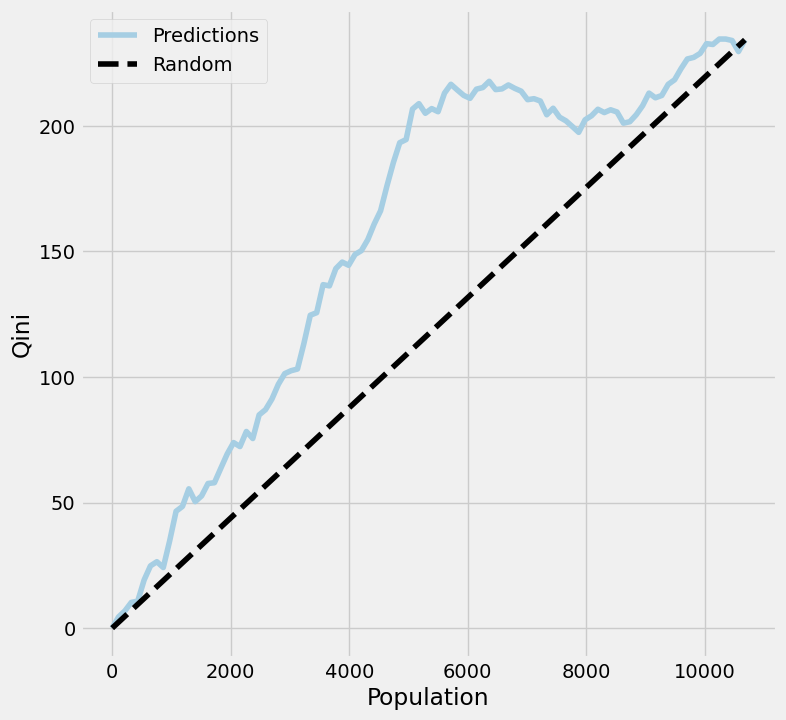

In [23]:
plot_qini(df_preds_2M_FS,outcome_col='outcome',treatment_col='treatment')

# Learn an uplift using UB-DT from the KUPLIFT library <a class="anchor" id="5"></a>
https://github.com/UData-Orange/kuplift

### Split to train and test splits

In [24]:
df_train, df_test=train_test_split(hillstrom_df)
input_variables = hillstrom_df.drop([treatment_name, outcome_name], axis=1,inplace=False).columns

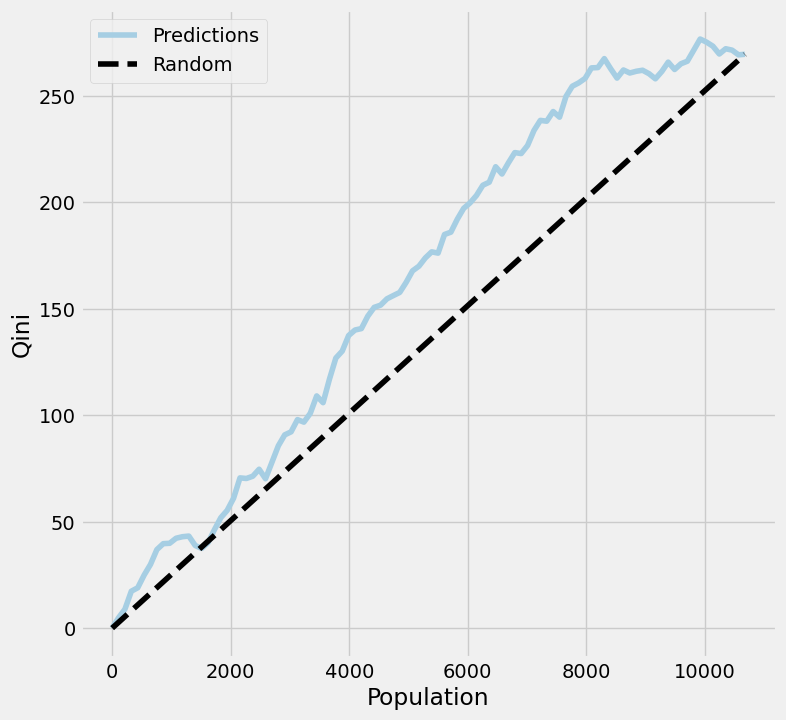

In [25]:
# Create a UB-DT model
tree = kp.BayesianDecisionTree()

# Fit the UB-DT model on the train data
tree.fit(df_train[input_variables], df_train[treatment_name], df_train[outcome_name])

# Get predictions from the test data
preds = tree.predict(df_test[input_variables])

# Create a predictions dataframe
df_preds_DT = create_prediction_table(df_test, preds, treatment_name, outcome_name)

# Calculate qini
qini = qini_auc_score(y_true=df_preds_DT['outcome'], uplift=df_preds_DT['Predictions'], treatment=df_preds_DT['treatment'])

# Plot a qini curve
plot_qini(df_preds_DT,outcome_col='outcome',treatment_col='treatment')

In [26]:
print(qini)

0.047763365324337725


# Learn an uplift using UB-RF from the KUPLIFT library <a class="anchor" id="6"></a>
https://github.com/UData-Orange/kuplift

0.06676678739299997


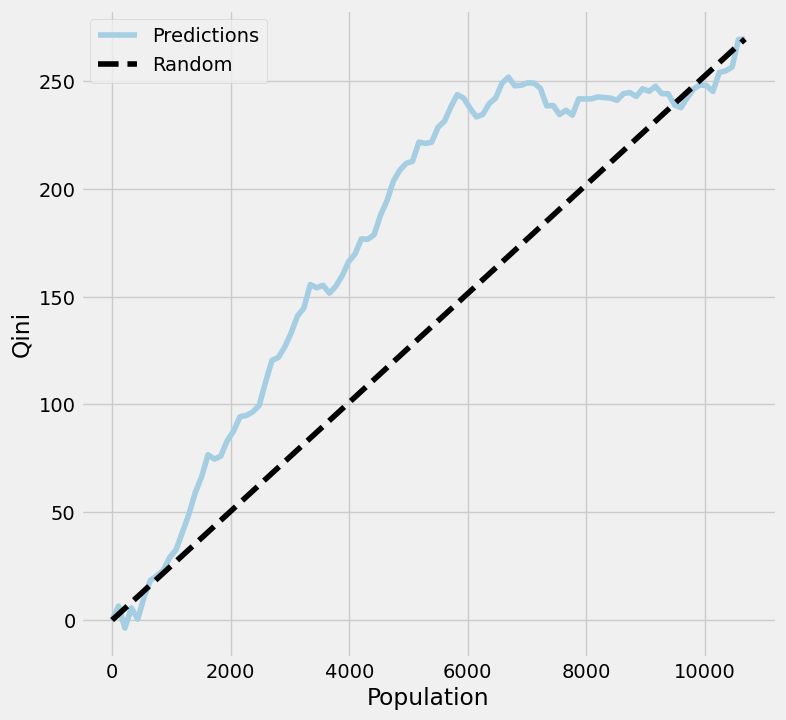

In [27]:
# Create a UB-RF model
forest = kp.BayesianRandomForest(n_trees=10)

# Fit the UB-DT model on the train data
forest.fit(df_train[input_variables], df_train[treatment_name], df_train[outcome_name])

# Get predictions from the test data
preds = forest.predict(df_test[input_variables])

# Create a predictions dataframe
df_preds_RF = create_prediction_table(df_test, preds, treatment_name, outcome_name)

# Calculate qini
qini = qini_auc_score(y_true=df_preds_RF['outcome'], uplift=df_preds_RF['Predictions'], treatment=df_preds_RF['treatment'])
print(qini)

# Plot a qini curve
plot_qini(df_preds_RF,outcome_col='outcome',treatment_col='treatment')

# Implement the class transformation approach <a class="anchor" id="7"></a>

## Description:

Le principe de cette approche est de cartographier le problème de modélisation de l'uplift à un problème d'apprentissage supervisé habituel. La variable de résultat `Y` est transformée en une variable `Z` comme illustré ci-dessous. Ensuite, un algorithme d'apprentissage automatique est utilisé pour apprendre un modèle et pour prédire `P(Z|X)`. L'uplift estimé d'un individu `i` est `τ̂i = 2 * P(Z=1|X_i) - 1`.

$$
Z = 
\begin{cases} 
1, & \text{si } T=1 \text{ et } Y=1 \\
1, & \text{si } T=0 \text{ et } Y=0 \\
0, & \text{sinon}
\end{cases}
$$




qini is  0.006524575101532788


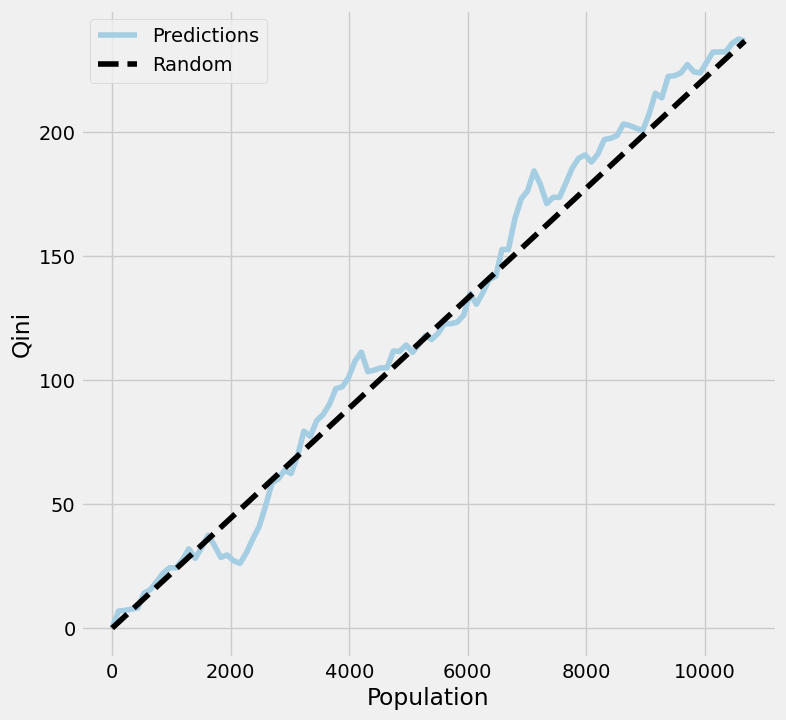

In [28]:
# Get train and test splits
df_train, df_test=train_test_split(hillstrom_df)

# Create a new column called Z and fill it accordingly
df_train['Z'] = [1 if x == y else 0 for x, y in zip(df_train[treatment_name], df_train[outcome_name])]

# Create a classification model
Classifier=RandomForestClassifier(n_estimators=5, random_state=99)

# Train the classifier on train data on the whole data with Z as the target variable
Classifier.fit(df_train[input_variables].values, df_train['Z'])

# get predictions
preds=Classifier.predict_proba(df_test[input_variables].values)

# get predictions for the positive class probability
predictions = [pred[1] for pred in preds]

# calculate uplift using the formula: uplift=((2 * P(Z=1|X_i)) - 1)
uplifts = [2*a_i-1 for a_i in predictions]

# Create predictions dataframe
df_preds_CT = create_prediction_table(df_test, uplifts, treatment_name, outcome_name)

# Evaluate using the qini metric
qini = qini_auc_score(y_true=df_preds_CT['outcome'], uplift=df_preds_CT['Predictions'], treatment=df_preds_CT['treatment'])

print("qini is ",qini)

# plot the qini curve
plot_qini(df_preds_CT,outcome_col='outcome',treatment_col='treatment')